 ## **Generative Adversarial Network with EfficientNetV2B0**

# Importing necessary Libraries and Modules

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

*Various types of layers used to construct neural networks.*

*GlobalAveragePooling2D, Concatenate, PReLU, LeakyReLU, Embedding are the Specialized layers and activations used in deep learning models.*

In [6]:
from tensorflow.keras.layers import Reshape, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, Input, Lambda, GlobalAveragePooling2D, Concatenate, PReLU, LeakyReLU, Embedding, multiply
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.optimizers import Adam

*Classes for creating Keras models*

In [8]:
from tensorflow.keras.models import Sequential, Model

In [9]:
from tensorflow.keras.utils import to_categorical, load_img, img_to_array

*ImageDataGenerator is used for image data augmentation to improve the generalization of the model*

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

*Callbacks to monitor the training process and make adjustments like stopping early if no improvement or reducing the learning rate.*

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger

*os and os.listdir: Used for interacting with the operating system, such as handling directories and files*

In [15]:
import os
from os import listdir

*A library for creating progress bars, also useful for tracking long-running operations*

In [17]:
from tqdm import tqdm

*Shutil is used for high-level file operations like copying files*

In [19]:
import shutil

In [20]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import time
import itertools
from sklearn.utils import resample  

*Functions for splitting datasets into training and testing sets and performing cross-validation*

In [22]:
from sklearn.model_selection import train_test_split, KFold

*Functions for evaluating the performance of models*

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Callbacks section

*Number of Epochs*

In [27]:
epochs = 125

*EarlyStopping: This callback monitors the performance of the model on the validation dataset*

In [29]:
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=epochs,
                          verbose=1,
                          restore_best_weights=True)

*ReduceLROnPlateau: This callback reduces the learning rate when a metric has stopped improving*

In [31]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

*CSVLogger: This callback streams epoch results to a CSV file*

In [33]:
csv_logger = CSVLogger('My_Model.log')

*Combining Callbacks*

In [35]:
callbacks = [earlystop, csv_logger, reduce_lr]

# Metrics and Loss Functions

*Intersection over Union (IoU): Measures the overlap between the predicted and true binary masks*

In [38]:
def iou(y_true, y_pred, smooth=0.5):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

*Sensitivity: Also known as recall, it measures the proportion of actual positives correctly identified*

In [40]:
def sensitivity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

*Specificity: Measures the proportion of actual negatives correctly identified*

In [42]:
def specificity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

*F1-Score: Harmonic mean of precision and recall. Precision: Proportion of predicted positives that are actual positives. Recall: Proportion of actual positives correctly identified.*

In [44]:
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

*Dice Coefficient: Measures the similarity between two samples, similar to IoU*

In [46]:
def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    dice_score = (2.0 * intersection + epsilon) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + epsilon)
    return dice_score

*Tversky Index: Generalization of the Dice coefficient that allows control over the penalty for false positives and false negatives*

In [48]:
def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

# Confusion Matrix Visualization

In [50]:
def confusion_matrix_img(y_pred, y_true, savename):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['benign', 'malignant']
    title='Confusion matrix'
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(savename)
    plt.show()

# Creating Directories for Augmented Data

*Sets a variable size to 128, to be used later for resizing images to 128x128 pixels*

In [53]:
size = 128

*Creating Directories*

In [55]:
os.makedirs('augmented/benign', exist_ok=True)
os.makedirs('augmented/malignant', exist_ok=True)

# Defining a Function to List All Files in a Directory

*getListOfFiles, takes a directory name as an input and returns a list of all files*

In [58]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

# Copying Benign Images to the Augmented Directory

*This will organize and prepare data for augmentation by copying only PNG images from the source directory ('/Users/renitalewis/Downloads/archive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign') to the target directory ('augmented/benign')*

In [61]:
files_benign = getListOfFiles('/Users/renitalewis/Downloads/archive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign')
for f in files_benign:
    if f.endswith('.png'):
        shutil.copy(f, 'augmented/benign')

# Copying Malignant Images to the Augmented Directory

*This will organize and prepare data for augmentation by copying only PNG images from the source directory ('/Users/renitalewis/Downloads/archive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant') to the target directory ('augmented/malignant')*

In [64]:
files_malignant = getListOfFiles('/Users/renitalewis/Downloads/archive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant')
for f in files_malignant:
    if f.endswith('.png'):
        shutil.copy(f, 'augmented/malignant')

# Listing Files in Augmented Directories

In [66]:
benign_images = getListOfFiles('augmented/benign')
malignent_images = getListOfFiles('augmented/malignant')

# Load and Display an Image

*Loading and Displaying a Benign Image*

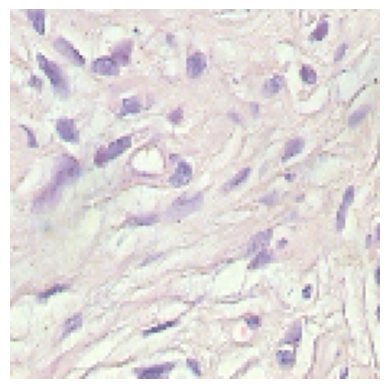

In [69]:
image_path = benign_images[9]
img = load_img(image_path, target_size=(size, size), color_mode='rgb')
img_array = img_to_array(img)
plt.imshow(img_array.astype('uint8'))
plt.axis('off')
plt.show()

*Loading and Displaying a Malignant Image*

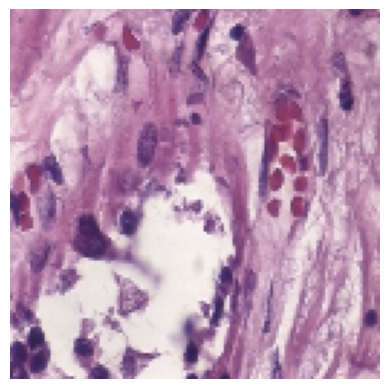

In [71]:
image_path = malignent_images[45]
img = load_img(image_path, target_size=(size, size), color_mode='rgb')
img_array = img_to_array(img)
plt.imshow(img_array.astype('uint8'))
plt.axis('off')
plt.show()

# Preparing the DataFrame

*Calculating Total Number of Images*

In [74]:
total_images = len(benign_images) + len(malignent_images)

*Creating the DataFrame*

In [76]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["image", "target"])

In [77]:
k = 0
for c, image_list in enumerate([benign_images, malignent_images]):
    for image_path in image_list:
        data.loc[k, "image"] = image_path
        data.loc[k, "target"] = c
        k += 1

print(data.shape)
print(data.head())

(7909, 2)
                                             image target
0  augmented/benign/SOB_B_F-14-23060CD-100-001.png      0
1  augmented/benign/SOB_B_TA-14-19854C-200-016.png      0
2  augmented/benign/SOB_B_TA-14-19854C-200-002.png      0
3    augmented/benign/SOB_B_F-14-25197-400-039.png      0
4   augmented/benign/SOB_B_F-14-14134E-100-007.png      0


# Balancing the Dataset

*Counting Class Instances, Resampling Benign Class, Concatenating DataFrames, Verifying the Balanced Dataset*

In [80]:
count_data = data["target"].value_counts()
ben_upsampled = resample(data[data['target']==0], n_samples=data[data['target']==1].shape[0], random_state=42)
up_sampled = pd.concat([data[data['target']==1], ben_upsampled])
up_sampled['target'].value_counts()

target
1    5429
0    5429
Name: count, dtype: int64

# Loading and Preprocessing Images

*Initializing Lists*

In [83]:
train_image = []
y = []

*Loading Images with Progress Bar*

In [85]:
for i in tqdm(range(up_sampled.shape[0])):
    img = tf.keras.utils.load_img(up_sampled['image'].iloc[i], target_size=(size, size), color_mode='rgb')
    img = tf.keras.utils.img_to_array(img)
    img = img / 255.0
    train_image.append(img)

100%|████████████████████████████████████| 10858/10858 [01:05<00:00, 166.85it/s]


*Converting Lists to Arrays*

In [87]:
X = np.array(train_image)
y = up_sampled.iloc[:, -1].values

# K-Fold Cross-Validation Split

*Initializing K-Fold*

In [90]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

*The First Split*

In [92]:
for train_index, test_index in kf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

*The Second Split (Validation Split)*

In [94]:
for train_index, test_index in kf.split(X_test, y_test):
    X2_test, X_val, y2_test, y_val = X_test[train_index], X_test[test_index], y_test[train_index], y_test[test_index]

# One-Hot Encoding Labels

In [96]:
Y_train = to_categorical(y_train, 2)
Y_test = to_categorical(y2_test, 2)
Y_val = to_categorical(y_val, 2)

print(X_train.shape)
print(X2_test.shape)
print(X_val.shape)

(9773, 128, 128, 3)
(977, 128, 128, 3)
(108, 128, 128, 3)


# Data Augmentation

In [98]:
data_gen = ImageDataGenerator(
    zoom_range=1.2,  
    rotation_range=90,
    width_shift_range=0.5,
    height_shift_range=0.5,
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,  # randomly flip images
)

*Fitting Data Generators*

In [100]:
data_gen.fit(X_train)
data_gen.fit(X_val)
data_gen.fit(X2_test)

# The Generator Architecture

In [102]:
def build_generator(noise_dim, img_shape):
    model = Sequential()
    
    model.add(Dense(256, input_dim=noise_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    noise = Input(shape=(noise_dim,))
    img = model(noise)

    return Model(noise, img)

# The Discriminator Architecture

In [104]:
def build_discriminator(img_shape):
    model = Sequential()
    
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

# Setting Image Shape and Noise Dimension

*The Image Shape*

In [107]:
img_shape = (size, size, 3)

*The Noise Dimension*

In [109]:
noise_dim = 100

# Building the Discriminator

In [111]:
discriminator = build_discriminator(img_shape)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


# Compiling the Discriminator

In [136]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Building the Generator

In [139]:
generator = build_generator(noise_dim, img_shape)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


# Generator Inputs and Outputs

In [142]:
z = Input(shape=(noise_dim,))
img = generator(z)

# Setting Up the Combined Model

*Freezing Discriminator Layers*

In [146]:
discriminator.trainable = False

*Passing Generated Images to Discriminator. The discriminator takes generated images as input and determines validity*

In [149]:
valid = discriminator(img)

*Defining the Combined Model*

In [152]:
gan = Model(z, valid)

*Compiling the Combined Model*

In [155]:
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Training the ACGAN-WGAN-GP

*Defining the Training Function*

*The training Loop*

In [160]:
def train_gan(epochs, batch_size, save_interval):
    
    X_train_gan = X_train * 2 - 1  
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train_gan.shape[0], batch_size)
        imgs = X_train_gan[idx]

        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        g_loss = gan.train_on_batch(noise, valid)

        
        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

        
        if epoch % save_interval == 0:
            save_imgs(epoch)

# Saving Generated Images

*Defining the Save Images Function*

In [164]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, noise_dim))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

# Calling the Training Function

In [167]:
train_gan(epochs=125, batch_size=4, save_interval=20) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.40911734104156494 | D accuracy: 93.75] [G loss: [array(0.49996412, dtype=float32), array(0.49996412, dtype=float32), array(0.875, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1 [D loss: 0.46542513370513916 | D accuracy: 83.33333730697632] [G loss: [array(0.49817502, dtype=float32), array(0.49817502, dtype=float32), array(0.75, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2 [D loss: 0.47586488723754883 | D accuracy: 79.58333492279053] [G loss: [array(0.4868822, dtype=float32), array(0.4868822, dtype=float32), array(0.7916667, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3 [D loss: 0.4827905297279358 | D accuracy: 80.13392686843872] [G loss: [array(0.49997437, dtype=float32), array(0.49997437, dtype=float32), array(0.78125, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4 [D loss: 0.4949255585670471 | D accuracy: 76.52778029441833] [G loss: [array(0.51353514, dtype=float32), array(0.51353514, dtype=f

# Function Definition

In [170]:
def generate_images(generator, num_images, noise_dim):
    noise = np.random.normal(0, 1, (num_images, noise_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]
    return gen_imgs

# Generating a Set of Synthetic Images

*Specifying Number of Synthetic Images*

In [175]:
num_synthetic_images = 1000

*Generating Synthetic Images*

In [180]:
synthetic_images = generate_images(generator, num_synthetic_images, noise_dim)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


# Adding Synthetic Images to the Training Set

*Concatenate Synthetic Images to Training Set*

In [184]:
X_train_augmented = np.concatenate((X_train, synthetic_images))

*Concatenate Labels for Synthetic Images*

In [189]:
y_train_augmented = np.concatenate((y_train, np.full((num_synthetic_images,), 1)))  

# One-Hot Encoding Labels

In [192]:
Y_train_augmented = to_categorical(y_train_augmented, 2)

*Setting Up Distributed Training*

*Initializing MirroredStrategy and Printing the Number of Devices*

In [196]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


# Function Definitions

*Bottleneck with EfficientNet*

In [200]:
def bottleneck0(inputs):
    backbone = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
    x = backbone(inputs)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)  # Bottleneck layer with EfficientNet
    x = Flatten()(x)
    return x

*The Neck Section*

In [203]:
def neck_section(inputs):
    x = Conv2D(256, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = PReLU()(x)  # Use PReLU directly as a layer
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Flatten()(x)
    return x

*Vision Transform*

In [206]:
def vision_transform(inputs, patch_size):
    x = Reshape((patch_size[0], patch_size[1], -1))(inputs)
    x = Lambda(lambda image: tf.cast(image, 'float32') / 255.0)(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return x

*Creating the Model*

In [209]:
def create_model(input_shape, num_classes, patch_size):
    inputs = Input(shape=input_shape)
    efficientnet_bottleneck = bottleneck0(inputs)
    patches_transform = vision_transform(inputs, patch_size)
    neck = neck_section(inputs)
    merged = Concatenate()([efficientnet_bottleneck, patches_transform, neck])
    outputs = Dense(num_classes, activation='softmax')(merged)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Model Setup and Compilation

*Model Parameters*

In [213]:
input_shape = (size, size, 3)
num_classes = 2
patch_size = (32, 32)
batch_size = 16

*Distributed Training Strategy*

In [216]:
with strategy.scope():
    model = create_model(input_shape, num_classes, patch_size)
    model.compile(loss="categorical_crossentropy",
                  optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.AUC(name='AUC'),
                           f1_score, specificity, sensitivity, iou, tversky])

# Model Summary

*Printing The Model Information*

In [220]:
print(model.input_shape)
print(model.output_shape)
model.summary()

(None, 128, 128, 3)
(None, 2)


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 32, 32,    │          0 │ input_layer_8[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 32, 32,    │          0 │ reshape_2[0][0]   │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │     27,712 │ lambda[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 4, 4,      │  5,919,312 │ input_layer_8[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     37,888 │ input_layer_8[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1280)      │      5,120 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 10, 10,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 64, 64,    │  1,048,576 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │    327,936 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 5, 5, 128) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ p_re_lu[0][0]     │
│ (MaxPooling2D)      │ 256)              │            │                 

 Total params: 8,157,138 (31.12 MB)

 Trainable params: 8,093,458 (30.87 MB)

 Non-trainable params: 63,680 (248.75 KB)

# Training the Model

In [240]:
history = model.fit(data_gen.flow(X_train_augmented, Y_train_augmented,
                                       batch_size=batch_size, 
                                       seed=27,
                                       shuffle=True),
                    callbacks=callbacks,
                    epochs=50,
                    steps_per_epoch=X_train_augmented.shape[0] // batch_size,
                    validation_data=data_gen.flow(X_val, Y_val,
                                       batch_size=batch_size, 
                                       seed=27,
                                       shuffle=True))

Epoch 1/50


2024-08-09 22:19:40.501182: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - AUC: 0.8221 - accuracy: 0.7519 - f1_score: 0.7499 - iou: 0.5980 - loss: 0.8900 - precision: 0.7519 - recall: 0.7519 - sensitivity: 0.7499 - specificity: 0.7499 - tversky: 0.7487

2024-08-09 22:25:29.803023: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 350s 520ms/step - AUC: 0.8221 - accuracy: 0.7519 - f1_score: 0.7499 - iou: 0.5980 - loss: 0.8898 - precision: 0.7519 - recall: 0.7519 - sensitivity: 0.7499 - specificity: 0.7499 - tversky: 0.7487 - val_AUC: 0.5575 - val_accuracy: 0.5370 - val_f1_score: 0.5446 - val_iou: 0.4053 - val_loss: 3.6509 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5446 - val_specificity: 0.5446 - val_tversky: 0.5729 - learning_rate: 0.0010
Epoch 2/50


2024-08-09 22:25:30.503969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 22:25:30.648025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 6:04 543ms/step - AUC: 0.7422 - accuracy: 0.6250 - f1_score: 0.6250 - iou: 0.4742 - loss: 1.1928 - precision: 0.6250 - recall: 0.6250 - sensitivity: 0.6250 - specificity: 0.6250 - tversky: 0.6539

2024-08-09 22:25:31.194335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]
/opt/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7422 - accuracy: 0.6250 - f1_score: 0.3130 - iou: 0.2375 - loss: 1.1928 - precision: 0.6250 - recall: 0.6250 - sensitivity: 0.3130 - specificity: 0.3130 - tversky: 0.3274 - val_AUC: 0.6376 - val_accuracy: 0.5370 - val_f1_score: 0.5357 - val_iou: 0.3925 - val_loss: 2.2501 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5357 - val_specificity: 0.5357 - val_tversky: 0.5703 - learning_rate: 0.0010
Epoch 3/50


2024-08-09 22:25:31.983746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - AUC: 0.8528 - accuracy: 0.7715 - f1_score: 0.7715 - iou: 0.6118 - loss: 0.6137 - precision: 0.7715 - recall: 0.7715 - sensitivity: 0.7715 - specificity: 0.7715 - tversky: 0.7611

2024-08-09 22:30:56.503114: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 325s 483ms/step - AUC: 0.8528 - accuracy: 0.7715 - f1_score: 0.7715 - iou: 0.6118 - loss: 0.6138 - precision: 0.7715 - recall: 0.7715 - sensitivity: 0.7715 - specificity: 0.7715 - tversky: 0.7611 - val_AUC: 0.6217 - val_accuracy: 0.5741 - val_f1_score: 0.5804 - val_iou: 0.4331 - val_loss: 2.4195 - val_precision: 0.5741 - val_recall: 0.5741 - val_sensitivity: 0.5804 - val_specificity: 0.5804 - val_tversky: 0.6066 - learning_rate: 0.0010
Epoch 4/50


2024-08-09 22:30:57.285721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 22:30:57.398659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:48 519ms/step - AUC: 0.7656 - accuracy: 0.7500 - f1_score: 0.7500 - iou: 0.5529 - loss: 1.1315 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.7500 - specificity: 0.7500 - tversky: 0.7206

2024-08-09 22:30:57.919301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7656 - accuracy: 0.7500 - f1_score: 0.3756 - iou: 0.2769 - loss: 1.1315 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.3756 - specificity: 0.3756 - tversky: 0.3608 - val_AUC: 0.6052 - val_accuracy: 0.5833 - val_f1_score: 0.5863 - val_iou: 0.4245 - val_loss: 2.6653 - val_precision: 0.5833 - val_recall: 0.5833 - val_sensitivity: 0.5863 - val_specificity: 0.5863 - val_tversky: 0.6018 - learning_rate: 0.0010
Epoch 5/50


2024-08-09 22:30:58.669544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - AUC: 0.8511 - accuracy: 0.7721 - f1_score: 0.7723 - iou: 0.6046 - loss: 0.5897 - precision: 0.7721 - recall: 0.7721 - sensitivity: 0.7723 - specificity: 0.7723 - tversky: 0.7558

2024-08-09 22:36:18.927278: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 321s 477ms/step - AUC: 0.8511 - accuracy: 0.7721 - f1_score: 0.7723 - iou: 0.6046 - loss: 0.5897 - precision: 0.7721 - recall: 0.7721 - sensitivity: 0.7723 - specificity: 0.7723 - tversky: 0.7558 - val_AUC: 0.6404 - val_accuracy: 0.5556 - val_f1_score: 0.5476 - val_iou: 0.4254 - val_loss: 1.3724 - val_precision: 0.5556 - val_recall: 0.5556 - val_sensitivity: 0.5476 - val_specificity: 0.5476 - val_tversky: 0.6000 - learning_rate: 0.0010
Epoch 6/50


2024-08-09 22:36:19.655386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 22:36:19.799893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:57 532ms/step - AUC: 0.9492 - accuracy: 0.8125 - f1_score: 0.8125 - iou: 0.6942 - loss: 0.2994 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.8125 - specificity: 0.8125 - tversky: 0.8248

2024-08-09 22:36:20.333246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9492 - accuracy: 0.8125 - f1_score: 0.4069 - iou: 0.3476 - loss: 0.2994 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.4069 - specificity: 0.4069 - tversky: 0.4130 - val_AUC: 0.6706 - val_accuracy: 0.5463 - val_f1_score: 0.5476 - val_iou: 0.4311 - val_loss: 1.1630 - val_precision: 0.5463 - val_recall: 0.5463 - val_sensitivity: 0.5476 - val_specificity: 0.5476 - val_tversky: 0.6104 - learning_rate: 0.0010
Epoch 7/50


2024-08-09 22:36:21.115599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - AUC: 0.8609 - accuracy: 0.7735 - f1_score: 0.7735 - iou: 0.6028 - loss: 0.5206 - precision: 0.7735 - recall: 0.7735 - sensitivity: 0.7735 - specificity: 0.7735 - tversky: 0.7551

2024-08-09 22:41:47.734306: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 327s 486ms/step - AUC: 0.8609 - accuracy: 0.7735 - f1_score: 0.7735 - iou: 0.6028 - loss: 0.5205 - precision: 0.7735 - recall: 0.7735 - sensitivity: 0.7735 - specificity: 0.7735 - tversky: 0.7551 - val_AUC: 0.6290 - val_accuracy: 0.4907 - val_f1_score: 0.4970 - val_iou: 0.3815 - val_loss: 2.0640 - val_precision: 0.4907 - val_recall: 0.4907 - val_sensitivity: 0.4970 - val_specificity: 0.4970 - val_tversky: 0.5619 - learning_rate: 0.0010
Epoch 8/50


2024-08-09 22:41:48.476453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 22:41:48.576145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:09 461ms/step - AUC: 0.9414 - accuracy: 0.9375 - f1_score: 0.9375 - iou: 0.7487 - loss: 0.2607 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.9375 - specificity: 0.9375 - tversky: 0.8605

2024-08-09 22:41:49.038732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9414 - accuracy: 0.9375 - f1_score: 0.4694 - iou: 0.3749 - loss: 0.2607 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.4694 - specificity: 0.4694 - tversky: 0.4309 - val_AUC: 0.6176 - val_accuracy: 0.5648 - val_f1_score: 0.5714 - val_iou: 0.4007 - val_loss: 2.1326 - val_precision: 0.5648 - val_recall: 0.5648 - val_sensitivity: 0.5714 - val_specificity: 0.5714 - val_tversky: 0.5776 - learning_rate: 0.0010
Epoch 9/50


2024-08-09 22:41:49.853377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - AUC: 0.8670 - accuracy: 0.7886 - f1_score: 0.7886 - iou: 0.6053 - loss: 0.4969 - precision: 0.7886 - recall: 0.7886 - sensitivity: 0.7886 - specificity: 0.7886 - tversky: 0.7579

2024-08-09 22:47:11.657849: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 323s 479ms/step - AUC: 0.8670 - accuracy: 0.7886 - f1_score: 0.7886 - iou: 0.6053 - loss: 0.4969 - precision: 0.7886 - recall: 0.7886 - sensitivity: 0.7886 - specificity: 0.7886 - tversky: 0.7579 - val_AUC: 0.7970 - val_accuracy: 0.7407 - val_f1_score: 0.7411 - val_iou: 0.5787 - val_loss: 1.0031 - val_precision: 0.7407 - val_recall: 0.7407 - val_sensitivity: 0.7411 - val_specificity: 0.7411 - val_tversky: 0.7389 - learning_rate: 0.0010
Epoch 10/50


2024-08-09 22:47:12.382861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 22:47:12.526381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 6:32 584ms/step - AUC: 0.9727 - accuracy: 0.9375 - f1_score: 0.9375 - iou: 0.7975 - loss: 0.1751 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.9375 - specificity: 0.9375 - tversky: 0.8907

2024-08-09 22:47:13.130640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.9727 - accuracy: 0.9375 - f1_score: 0.4694 - iou: 0.3994 - loss: 0.1751 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.4694 - specificity: 0.4694 - tversky: 0.4460 - val_AUC: 0.8332 - val_accuracy: 0.7685 - val_f1_score: 0.7708 - val_iou: 0.6177 - val_loss: 0.7891 - val_precision: 0.7685 - val_recall: 0.7685 - val_sensitivity: 0.7708 - val_specificity: 0.7708 - val_tversky: 0.7668 - learning_rate: 0.0010
Epoch 11/50


2024-08-09 22:47:13.949646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - AUC: 0.8698 - accuracy: 0.7846 - f1_score: 0.7848 - iou: 0.6059 - loss: 0.4880 - precision: 0.7846 - recall: 0.7846 - sensitivity: 0.7848 - specificity: 0.7848 - tversky: 0.7580

2024-08-09 22:52:51.168430: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 338s 502ms/step - AUC: 0.8698 - accuracy: 0.7846 - f1_score: 0.7848 - iou: 0.6059 - loss: 0.4880 - precision: 0.7846 - recall: 0.7846 - sensitivity: 0.7848 - specificity: 0.7848 - tversky: 0.7580 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5476 - val_iou: 0.4028 - val_loss: 112.0455 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5476 - val_specificity: 0.5476 - val_tversky: 0.5747 - learning_rate: 0.0010
Epoch 12/50


2024-08-09 22:52:51.938815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 22:52:52.049887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 6:51 612ms/step - AUC: 0.9727 - accuracy: 0.9375 - f1_score: 0.9375 - iou: 0.7634 - loss: 0.2029 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.9375 - specificity: 0.9375 - tversky: 0.8698

2024-08-09 22:52:52.664280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.9727 - accuracy: 0.9375 - f1_score: 0.4694 - iou: 0.3823 - loss: 0.2029 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.4694 - specificity: 0.4694 - tversky: 0.4355 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5446 - val_iou: 0.4005 - val_loss: 103.7679 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5446 - val_specificity: 0.5446 - val_tversky: 0.5721 - learning_rate: 0.0010
Epoch 13/50


2024-08-09 22:52:53.489432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - AUC: 0.8681 - accuracy: 0.7857 - f1_score: 0.7859 - iou: 0.6046 - loss: 0.4975 - precision: 0.7857 - recall: 0.7857 - sensitivity: 0.7859 - specificity: 0.7859 - tversky: 0.7566

2024-08-09 22:58:23.994704: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 331s 492ms/step - AUC: 0.8681 - accuracy: 0.7857 - f1_score: 0.7859 - iou: 0.6046 - loss: 0.4975 - precision: 0.7857 - recall: 0.7857 - sensitivity: 0.7859 - specificity: 0.7859 - tversky: 0.7566 - val_AUC: 0.5187 - val_accuracy: 0.4630 - val_f1_score: 0.4673 - val_iou: 0.3286 - val_loss: 5.2525 - val_precision: 0.4630 - val_recall: 0.4630 - val_sensitivity: 0.4673 - val_specificity: 0.4673 - val_tversky: 0.5064 - learning_rate: 0.0010
Epoch 14/50


2024-08-09 22:58:24.723266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 22:58:24.829758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 7:12 644ms/step - AUC: 0.7676 - accuracy: 0.6250 - f1_score: 0.6250 - iou: 0.4885 - loss: 0.5961 - precision: 0.6250 - recall: 0.6250 - sensitivity: 0.6250 - specificity: 0.6250 - tversky: 0.6665

2024-08-09 22:58:25.483627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.7676 - accuracy: 0.6250 - f1_score: 0.3130 - iou: 0.2446 - loss: 0.5961 - precision: 0.6250 - recall: 0.6250 - sensitivity: 0.3130 - specificity: 0.3130 - tversky: 0.3337 - val_AUC: 0.5316 - val_accuracy: 0.4630 - val_f1_score: 0.4762 - val_iou: 0.3510 - val_loss: 5.3072 - val_precision: 0.4630 - val_recall: 0.4630 - val_sensitivity: 0.4762 - val_specificity: 0.4762 - val_tversky: 0.5151 - learning_rate: 0.0010
Epoch 15/50


2024-08-09 22:58:26.250416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - AUC: 0.8650 - accuracy: 0.7860 - f1_score: 0.7859 - iou: 0.5929 - loss: 0.4830 - precision: 0.7860 - recall: 0.7860 - sensitivity: 0.7859 - specificity: 0.7859 - tversky: 0.7483

2024-08-09 23:03:44.441144: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
673/673 ━━━━━━━━━━━━━━━━━━━━ 319s 474ms/step - AUC: 0.8650 - accuracy: 0.7860 - f1_score: 0.7859 - iou: 0.5929 - loss: 0.4830 - precision: 0.7860 - recall: 0.7860 - sensitivity: 0.7859 - specificity: 0.7859 - tversky: 0.7483 - val_AUC: 0.7063 - val_accuracy: 0.6574 - val_f1_score: 0.6637 - val_iou: 0.5010 - val_loss: 1.3278 - val_precision: 0.6574 - val_recall: 0.6574 - val_sensitivity: 0.6637 - val_specificity: 0.6637 - val_tversky: 0.6637 - learning_rate: 0.0010
Epoch 16/50


2024-08-09 23:03:45.240965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 23:03:45.359516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 6:24 573ms/step - AUC: 0.9531 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.6943 - loss: 0.2541 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.8249

2024-08-09 23:03:45.934570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9531 - accuracy: 0.8750 - f1_score: 0.4382 - iou: 0.3477 - loss: 0.2541 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4382 - specificity: 0.4382 - tversky: 0.4131 - val_AUC: 0.6757 - val_accuracy: 0.6111 - val_f1_score: 0.6190 - val_iou: 0.4699 - val_loss: 1.6003 - val_precision: 0.6111 - val_recall: 0.6111 - val_sensitivity: 0.6190 - val_specificity: 0.6190 - val_tversky: 0.6418 - learning_rate: 2.0000e-04
Epoch 17/50


2024-08-09 23:03:46.727683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - AUC: 0.8949 - accuracy: 0.8147 - f1_score: 0.8135 - iou: 0.6142 - loss: 0.4183 - precision: 0.8147 - recall: 0.8147 - sensitivity: 0.8135 - specificity: 0.8135 - tversky: 0.7652

2024-08-09 23:09:06.139740: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 320s 475ms/step - AUC: 0.8949 - accuracy: 0.8147 - f1_score: 0.8135 - iou: 0.6142 - loss: 0.4183 - precision: 0.8147 - recall: 0.8147 - sensitivity: 0.8135 - specificity: 0.8135 - tversky: 0.7652 - val_AUC: 0.8376 - val_accuracy: 0.7315 - val_f1_score: 0.7321 - val_iou: 0.5776 - val_loss: 0.5754 - val_precision: 0.7315 - val_recall: 0.7315 - val_sensitivity: 0.7321 - val_specificity: 0.7321 - val_tversky: 0.7361 - learning_rate: 2.0000e-04
Epoch 18/50


2024-08-09 23:09:06.881452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 23:09:07.032851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 6:58 623ms/step - AUC: 1.0000 - accuracy: 1.0000 - f1_score: 1.0000 - iou: 0.7613 - loss: 0.1642 - precision: 1.0000 - recall: 1.0000 - sensitivity: 1.0000 - specificity: 1.0000 - tversky: 0.8685

2024-08-09 23:09:07.660563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 1.0000 - accuracy: 1.0000 - f1_score: 0.5007 - iou: 0.3812 - loss: 0.1642 - precision: 1.0000 - recall: 1.0000 - sensitivity: 0.5007 - specificity: 0.5007 - tversky: 0.4349 - val_AUC: 0.8546 - val_accuracy: 0.7407 - val_f1_score: 0.7381 - val_iou: 0.5985 - val_loss: 0.5563 - val_precision: 0.7407 - val_recall: 0.7407 - val_sensitivity: 0.7381 - val_specificity: 0.7381 - val_tversky: 0.7524 - learning_rate: 2.0000e-04
Epoch 19/50


2024-08-09 23:09:08.435888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - AUC: 0.9036 - accuracy: 0.8242 - f1_score: 0.8242 - iou: 0.6223 - loss: 0.3988 - precision: 0.8242 - recall: 0.8242 - sensitivity: 0.8242 - specificity: 0.8242 - tversky: 0.7713

2024-08-09 23:14:26.571718: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 319s 473ms/step - AUC: 0.9036 - accuracy: 0.8242 - f1_score: 0.8242 - iou: 0.6223 - loss: 0.3988 - precision: 0.8242 - recall: 0.8242 - sensitivity: 0.8242 - specificity: 0.8242 - tversky: 0.7713 - val_AUC: 0.8570 - val_accuracy: 0.7778 - val_f1_score: 0.7798 - val_iou: 0.6027 - val_loss: 0.5336 - val_precision: 0.7778 - val_recall: 0.7778 - val_sensitivity: 0.7798 - val_specificity: 0.7798 - val_tversky: 0.7556 - learning_rate: 2.0000e-04
Epoch 20/50


2024-08-09 23:14:27.320102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 23:14:27.460202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 6:18 563ms/step - AUC: 0.9766 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.6574 - loss: 0.2706 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.7994

2024-08-09 23:14:28.026256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9766 - accuracy: 0.8750 - f1_score: 0.4382 - iou: 0.3292 - loss: 0.2706 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4382 - specificity: 0.4382 - tversky: 0.4003 - val_AUC: 0.8483 - val_accuracy: 0.7500 - val_f1_score: 0.7560 - val_iou: 0.5941 - val_loss: 0.5596 - val_precision: 0.7500 - val_recall: 0.7500 - val_sensitivity: 0.7560 - val_specificity: 0.7560 - val_tversky: 0.7468 - learning_rate: 2.0000e-04
Epoch 21/50


2024-08-09 23:14:28.779887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - AUC: 0.9065 - accuracy: 0.8282 - f1_score: 0.8285 - iou: 0.6224 - loss: 0.3896 - precision: 0.8282 - recall: 0.8282 - sensitivity: 0.8285 - specificity: 0.8285 - tversky: 0.7714

2024-08-09 23:19:52.607632: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 325s 482ms/step - AUC: 0.9065 - accuracy: 0.8282 - f1_score: 0.8285 - iou: 0.6224 - loss: 0.3896 - precision: 0.8282 - recall: 0.8282 - sensitivity: 0.8285 - specificity: 0.8285 - tversky: 0.7714 - val_AUC: 0.8203 - val_accuracy: 0.7500 - val_f1_score: 0.7530 - val_iou: 0.5671 - val_loss: 0.6210 - val_precision: 0.7500 - val_recall: 0.7500 - val_sensitivity: 0.7530 - val_specificity: 0.7530 - val_tversky: 0.7293 - learning_rate: 2.0000e-04
Epoch 22/50


2024-08-09 23:19:53.330602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 23:19:53.435462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 6:06 546ms/step - AUC: 0.6836 - accuracy: 0.6875 - f1_score: 0.6875 - iou: 0.4690 - loss: 0.9360 - precision: 0.6875 - recall: 0.6875 - sensitivity: 0.6875 - specificity: 0.6875 - tversky: 0.6492

2024-08-09 23:19:53.978522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.6836 - accuracy: 0.6875 - f1_score: 0.3443 - iou: 0.2348 - loss: 0.9360 - precision: 0.6875 - recall: 0.6875 - sensitivity: 0.3443 - specificity: 0.3443 - tversky: 0.3251 - val_AUC: 0.8434 - val_accuracy: 0.7778 - val_f1_score: 0.7798 - val_iou: 0.5714 - val_loss: 0.6009 - val_precision: 0.7778 - val_recall: 0.7778 - val_sensitivity: 0.7798 - val_specificity: 0.7798 - val_tversky: 0.7322 - learning_rate: 2.0000e-04
Epoch 23/50


2024-08-09 23:19:54.746577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - AUC: 0.9049 - accuracy: 0.8226 - f1_score: 0.8220 - iou: 0.6222 - loss: 0.3908 - precision: 0.8226 - recall: 0.8226 - sensitivity: 0.8220 - specificity: 0.8220 - tversky: 0.7715

2024-08-09 23:25:17.858036: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 324s 481ms/step - AUC: 0.9049 - accuracy: 0.8226 - f1_score: 0.8220 - iou: 0.6222 - loss: 0.3908 - precision: 0.8226 - recall: 0.8226 - sensitivity: 0.8220 - specificity: 0.8220 - tversky: 0.7715 - val_AUC: 0.8875 - val_accuracy: 0.7870 - val_f1_score: 0.7887 - val_iou: 0.5909 - val_loss: 0.4083 - val_precision: 0.7870 - val_recall: 0.7870 - val_sensitivity: 0.7887 - val_specificity: 0.7887 - val_tversky: 0.7440 - learning_rate: 2.0000e-04
Epoch 24/50


2024-08-09 23:25:18.553776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 23:25:18.695398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 6:24 572ms/step - AUC: 0.9219 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.6368 - loss: 0.3281 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.7846

2024-08-09 23:25:19.275195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9219 - accuracy: 0.8750 - f1_score: 0.4382 - iou: 0.3189 - loss: 0.3281 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4382 - specificity: 0.4382 - tversky: 0.3929 - val_AUC: 0.8689 - val_accuracy: 0.7963 - val_f1_score: 0.8006 - val_iou: 0.5764 - val_loss: 0.4603 - val_precision: 0.7963 - val_recall: 0.7963 - val_sensitivity: 0.8006 - val_specificity: 0.8006 - val_tversky: 0.7373 - learning_rate: 2.0000e-04
Epoch 25/50


2024-08-09 23:25:20.020589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - AUC: 0.9082 - accuracy: 0.8239 - f1_score: 0.8239 - iou: 0.6303 - loss: 0.3843 - precision: 0.8239 - recall: 0.8239 - sensitivity: 0.8239 - specificity: 0.8239 - tversky: 0.7768

2024-08-09 23:30:35.994725: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 317s 470ms/step - AUC: 0.9082 - accuracy: 0.8239 - f1_score: 0.8239 - iou: 0.6303 - loss: 0.3843 - precision: 0.8239 - recall: 0.8239 - sensitivity: 0.8239 - specificity: 0.8239 - tversky: 0.7768 - val_AUC: 0.8482 - val_accuracy: 0.8056 - val_f1_score: 0.8006 - val_iou: 0.6276 - val_loss: 0.7920 - val_precision: 0.8056 - val_recall: 0.8056 - val_sensitivity: 0.8006 - val_specificity: 0.8006 - val_tversky: 0.7760 - learning_rate: 2.0000e-04
Epoch 26/50


2024-08-09 23:30:36.734279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 23:30:36.833034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 6:03 541ms/step - AUC: 0.8750 - accuracy: 0.8125 - f1_score: 0.8125 - iou: 0.5626 - loss: 0.4083 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.8125 - specificity: 0.8125 - tversky: 0.7283

2024-08-09 23:30:37.375101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8750 - accuracy: 0.8125 - f1_score: 0.4069 - iou: 0.2817 - loss: 0.4083 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.4069 - specificity: 0.4069 - tversky: 0.3647 - val_AUC: 0.8350 - val_accuracy: 0.8148 - val_f1_score: 0.8185 - val_iou: 0.6365 - val_loss: 0.8584 - val_precision: 0.8148 - val_recall: 0.8148 - val_sensitivity: 0.8185 - val_specificity: 0.8185 - val_tversky: 0.7806 - learning_rate: 2.0000e-04
Epoch 27/50


2024-08-09 23:30:38.127407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - AUC: 0.9156 - accuracy: 0.8342 - f1_score: 0.8342 - iou: 0.6434 - loss: 0.3714 - precision: 0.8342 - recall: 0.8342 - sensitivity: 0.8342 - specificity: 0.8342 - tversky: 0.7867

2024-08-09 23:35:58.541684: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 321s 477ms/step - AUC: 0.9156 - accuracy: 0.8342 - f1_score: 0.8342 - iou: 0.6434 - loss: 0.3714 - precision: 0.8342 - recall: 0.8342 - sensitivity: 0.8342 - specificity: 0.8342 - tversky: 0.7867 - val_AUC: 0.8294 - val_accuracy: 0.7500 - val_f1_score: 0.7440 - val_iou: 0.5789 - val_loss: 0.6273 - val_precision: 0.7500 - val_recall: 0.7500 - val_sensitivity: 0.7440 - val_specificity: 0.7440 - val_tversky: 0.7398 - learning_rate: 2.0000e-04
Epoch 28/50


2024-08-09 23:35:59.275189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 23:35:59.378166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:46 516ms/step - AUC: 0.9531 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.7042 - loss: 0.2622 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.8315

2024-08-09 23:35:59.902551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]



Epoch 28: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9531 - accuracy: 0.8750 - f1_score: 0.4382 - iou: 0.3526 - loss: 0.2622 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4382 - specificity: 0.4382 - tversky: 0.4164 - val_AUC: 0.8988 - val_accuracy: 0.8148 - val_f1_score: 0.8185 - val_iou: 0.6440 - val_loss: 0.4228 - val_precision: 0.8148 - val_recall: 0.8148 - val_sensitivity: 0.8185 - val_specificity: 0.8185 - val_tversky: 0.7876 - learning_rate: 2.0000e-04
Epoch 29/50


2024-08-09 23:36:00.671155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - AUC: 0.9226 - accuracy: 0.8465 - f1_score: 0.8464 - iou: 0.6454 - loss: 0.3541 - precision: 0.8465 - recall: 0.8465 - sensitivity: 0.8464 - specificity: 0.8464 - tversky: 0.7883

2024-08-09 23:41:21.506545: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 322s 477ms/step - AUC: 0.9226 - accuracy: 0.8465 - f1_score: 0.8463 - iou: 0.6454 - loss: 0.3541 - precision: 0.8465 - recall: 0.8465 - sensitivity: 0.8463 - specificity: 0.8463 - tversky: 0.7883 - val_AUC: 0.9669 - val_accuracy: 0.8889 - val_f1_score: 0.8899 - val_iou: 0.6854 - val_loss: 0.2695 - val_precision: 0.8889 - val_recall: 0.8889 - val_sensitivity: 0.8899 - val_specificity: 0.8899 - val_tversky: 0.8173 - learning_rate: 4.0000e-05
Epoch 30/50


2024-08-09 23:41:22.255806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 23:41:22.407036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 6:06 545ms/step - AUC: 1.0000 - accuracy: 1.0000 - f1_score: 1.0000 - iou: 0.7448 - loss: 0.1735 - precision: 1.0000 - recall: 1.0000 - sensitivity: 1.0000 - specificity: 1.0000 - tversky: 0.8580

2024-08-09 23:41:22.957206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 1.0000 - accuracy: 1.0000 - f1_score: 0.5007 - iou: 0.3729 - loss: 0.1735 - precision: 1.0000 - recall: 1.0000 - sensitivity: 0.5007 - specificity: 0.5007 - tversky: 0.4297 - val_AUC: 0.9600 - val_accuracy: 0.8981 - val_f1_score: 0.9018 - val_iou: 0.6848 - val_loss: 0.2721 - val_precision: 0.8981 - val_recall: 0.8981 - val_sensitivity: 0.9018 - val_specificity: 0.9018 - val_tversky: 0.8171 - learning_rate: 4.0000e-05
Epoch 31/50


2024-08-09 23:41:23.721318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - AUC: 0.9183 - accuracy: 0.8387 - f1_score: 0.8387 - iou: 0.6420 - loss: 0.3639 - precision: 0.8387 - recall: 0.8387 - sensitivity: 0.8387 - specificity: 0.8387 - tversky: 0.7856

2024-08-09 23:46:58.442968: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 336s 498ms/step - AUC: 0.9183 - accuracy: 0.8387 - f1_score: 0.8387 - iou: 0.6420 - loss: 0.3639 - precision: 0.8387 - recall: 0.8387 - sensitivity: 0.8387 - specificity: 0.8387 - tversky: 0.7856 - val_AUC: 0.9647 - val_accuracy: 0.9167 - val_f1_score: 0.9137 - val_iou: 0.6872 - val_loss: 0.2637 - val_precision: 0.9167 - val_recall: 0.9167 - val_sensitivity: 0.9137 - val_specificity: 0.9137 - val_tversky: 0.8167 - learning_rate: 4.0000e-05
Epoch 32/50


2024-08-09 23:46:59.224529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 23:46:59.374848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 7:14 646ms/step - AUC: 0.8828 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.6243 - loss: 0.4372 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.7755

2024-08-09 23:47:00.019693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.8828 - accuracy: 0.8750 - f1_score: 0.4382 - iou: 0.3126 - loss: 0.4372 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4382 - specificity: 0.4382 - tversky: 0.3883 - val_AUC: 0.9569 - val_accuracy: 0.8981 - val_f1_score: 0.8958 - val_iou: 0.6848 - val_loss: 0.2764 - val_precision: 0.8981 - val_recall: 0.8981 - val_sensitivity: 0.8958 - val_specificity: 0.8958 - val_tversky: 0.8167 - learning_rate: 4.0000e-05
Epoch 33/50


2024-08-09 23:47:00.794875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - AUC: 0.9211 - accuracy: 0.8429 - f1_score: 0.8428 - iou: 0.6453 - loss: 0.3576 - precision: 0.8429 - recall: 0.8429 - sensitivity: 0.8428 - specificity: 0.8428 - tversky: 0.7880

2024-08-09 23:52:32.810037: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 333s 494ms/step - AUC: 0.9211 - accuracy: 0.8429 - f1_score: 0.8428 - iou: 0.6453 - loss: 0.3576 - precision: 0.8429 - recall: 0.8429 - sensitivity: 0.8428 - specificity: 0.8428 - tversky: 0.7880 - val_AUC: 0.9811 - val_accuracy: 0.9167 - val_f1_score: 0.9107 - val_iou: 0.7075 - val_loss: 0.2286 - val_precision: 0.9167 - val_recall: 0.9167 - val_sensitivity: 0.9107 - val_specificity: 0.9107 - val_tversky: 0.8318 - learning_rate: 4.0000e-05
Epoch 34/50


2024-08-09 23:52:33.650872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 23:52:33.797152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 6:27 577ms/step - AUC: 0.7891 - accuracy: 0.6875 - f1_score: 0.6875 - iou: 0.5410 - loss: 0.9328 - precision: 0.6875 - recall: 0.6875 - sensitivity: 0.6875 - specificity: 0.6875 - tversky: 0.7109

2024-08-09 23:52:34.379645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7891 - accuracy: 0.6875 - f1_score: 0.3443 - iou: 0.2709 - loss: 0.9328 - precision: 0.6875 - recall: 0.6875 - sensitivity: 0.3443 - specificity: 0.3443 - tversky: 0.3560 - val_AUC: 0.9768 - val_accuracy: 0.9167 - val_f1_score: 0.9167 - val_iou: 0.7086 - val_loss: 0.2351 - val_precision: 0.9167 - val_recall: 0.9167 - val_sensitivity: 0.9167 - val_specificity: 0.9167 - val_tversky: 0.8328 - learning_rate: 4.0000e-05
Epoch 35/50


2024-08-09 23:52:35.139978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - AUC: 0.9188 - accuracy: 0.8355 - f1_score: 0.8356 - iou: 0.6432 - loss: 0.3627 - precision: 0.8355 - recall: 0.8355 - sensitivity: 0.8356 - specificity: 0.8356 - tversky: 0.7865

2024-08-09 23:58:14.192940: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 340s 504ms/step - AUC: 0.9188 - accuracy: 0.8355 - f1_score: 0.8356 - iou: 0.6432 - loss: 0.3626 - precision: 0.8355 - recall: 0.8355 - sensitivity: 0.8356 - specificity: 0.8356 - tversky: 0.7865 - val_AUC: 0.9429 - val_accuracy: 0.8889 - val_f1_score: 0.8869 - val_iou: 0.6612 - val_loss: 0.3113 - val_precision: 0.8889 - val_recall: 0.8889 - val_sensitivity: 0.8869 - val_specificity: 0.8869 - val_tversky: 0.8000 - learning_rate: 4.0000e-05
Epoch 36/50


2024-08-09 23:58:14.915027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 23:58:15.014677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 6:24 572ms/step - AUC: 0.8906 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.6104 - loss: 0.4116 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.7652

2024-08-09 23:58:15.589324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8906 - accuracy: 0.8750 - f1_score: 0.4382 - iou: 0.3057 - loss: 0.4116 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4382 - specificity: 0.4382 - tversky: 0.3832 - val_AUC: 0.9767 - val_accuracy: 0.9259 - val_f1_score: 0.9286 - val_iou: 0.6958 - val_loss: 0.2419 - val_precision: 0.9259 - val_recall: 0.9259 - val_sensitivity: 0.9286 - val_specificity: 0.9286 - val_tversky: 0.8243 - learning_rate: 4.0000e-05
Epoch 37/50


2024-08-09 23:58:16.360916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - AUC: 0.9224 - accuracy: 0.8425 - f1_score: 0.8425 - iou: 0.6470 - loss: 0.3552 - precision: 0.8425 - recall: 0.8425 - sensitivity: 0.8425 - specificity: 0.8425 - tversky: 0.7891

2024-08-10 00:04:09.219371: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 354s 525ms/step - AUC: 0.9224 - accuracy: 0.8425 - f1_score: 0.8425 - iou: 0.6470 - loss: 0.3552 - precision: 0.8425 - recall: 0.8425 - sensitivity: 0.8425 - specificity: 0.8425 - tversky: 0.7891 - val_AUC: 0.9753 - val_accuracy: 0.9167 - val_f1_score: 0.9167 - val_iou: 0.7114 - val_loss: 0.2375 - val_precision: 0.9167 - val_recall: 0.9167 - val_sensitivity: 0.9167 - val_specificity: 0.9167 - val_tversky: 0.8345 - learning_rate: 4.0000e-05
Epoch 38/50


2024-08-10 00:04:09.939115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-10 00:04:10.042969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:43 511ms/step - AUC: 0.9336 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.6549 - loss: 0.3558 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.7976

2024-08-10 00:04:10.558305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]



Epoch 38: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9336 - accuracy: 0.8750 - f1_score: 0.4382 - iou: 0.3280 - loss: 0.3558 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4382 - specificity: 0.4382 - tversky: 0.3994 - val_AUC: 0.9550 - val_accuracy: 0.9074 - val_f1_score: 0.9077 - val_iou: 0.6896 - val_loss: 0.2888 - val_precision: 0.9074 - val_recall: 0.9074 - val_sensitivity: 0.9077 - val_specificity: 0.9077 - val_tversky: 0.8210 - learning_rate: 4.0000e-05
Epoch 39/50


2024-08-10 00:04:11.321968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - AUC: 0.9251 - accuracy: 0.8450 - f1_score: 0.8448 - iou: 0.6525 - loss: 0.3496 - precision: 0.8450 - recall: 0.8450 - sensitivity: 0.8448 - specificity: 0.8448 - tversky: 0.7931

2024-08-10 00:09:50.822527: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 340s 505ms/step - AUC: 0.9251 - accuracy: 0.8450 - f1_score: 0.8448 - iou: 0.6525 - loss: 0.3495 - precision: 0.8450 - recall: 0.8450 - sensitivity: 0.8448 - specificity: 0.8448 - tversky: 0.7931 - val_AUC: 0.9477 - val_accuracy: 0.8704 - val_f1_score: 0.8690 - val_iou: 0.6677 - val_loss: 0.3006 - val_precision: 0.8704 - val_recall: 0.8704 - val_sensitivity: 0.8690 - val_specificity: 0.8690 - val_tversky: 0.8052 - learning_rate: 8.0000e-06
Epoch 40/50


2024-08-10 00:09:51.561960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-10 00:09:51.668096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:28 489ms/step - AUC: 0.8750 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.6047 - loss: 0.4777 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.7609

2024-08-10 00:09:52.160425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8750 - accuracy: 0.8750 - f1_score: 0.4382 - iou: 0.3028 - loss: 0.4777 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4382 - specificity: 0.4382 - tversky: 0.3810 - val_AUC: 0.9746 - val_accuracy: 0.9352 - val_f1_score: 0.9345 - val_iou: 0.6857 - val_loss: 0.2510 - val_precision: 0.9352 - val_recall: 0.9352 - val_sensitivity: 0.9345 - val_specificity: 0.9345 - val_tversky: 0.8175 - learning_rate: 8.0000e-06
Epoch 41/50


2024-08-10 00:09:52.974497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - AUC: 0.9248 - accuracy: 0.8458 - f1_score: 0.8457 - iou: 0.6490 - loss: 0.3503 - precision: 0.8458 - recall: 0.8458 - sensitivity: 0.8457 - specificity: 0.8457 - tversky: 0.7908

2024-08-10 00:15:31.760639: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 340s 504ms/step - AUC: 0.9248 - accuracy: 0.8458 - f1_score: 0.8457 - iou: 0.6490 - loss: 0.3503 - precision: 0.8458 - recall: 0.8458 - sensitivity: 0.8457 - specificity: 0.8457 - tversky: 0.7908 - val_AUC: 0.9584 - val_accuracy: 0.8704 - val_f1_score: 0.8720 - val_iou: 0.6849 - val_loss: 0.2770 - val_precision: 0.8704 - val_recall: 0.8704 - val_sensitivity: 0.8720 - val_specificity: 0.8720 - val_tversky: 0.8165 - learning_rate: 8.0000e-06
Epoch 42/50


2024-08-10 00:15:32.509371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-10 00:15:32.617423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:28 488ms/step - AUC: 0.9375 - accuracy: 0.7500 - f1_score: 0.7500 - iou: 0.6346 - loss: 0.3196 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.7500 - specificity: 0.7500 - tversky: 0.7830

2024-08-10 00:15:33.109286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9375 - accuracy: 0.7500 - f1_score: 0.3756 - iou: 0.3178 - loss: 0.3196 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.3756 - specificity: 0.3756 - tversky: 0.3921 - val_AUC: 0.9771 - val_accuracy: 0.8981 - val_f1_score: 0.8988 - val_iou: 0.6861 - val_loss: 0.2488 - val_precision: 0.8981 - val_recall: 0.8981 - val_sensitivity: 0.8988 - val_specificity: 0.8988 - val_tversky: 0.8185 - learning_rate: 8.0000e-06
Epoch 43/50


2024-08-10 00:15:33.906347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - AUC: 0.9249 - accuracy: 0.8482 - f1_score: 0.8481 - iou: 0.6498 - loss: 0.3502 - precision: 0.8482 - recall: 0.8482 - sensitivity: 0.8481 - specificity: 0.8481 - tversky: 0.7917

2024-08-10 00:21:36.196977: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 43: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
673/673 ━━━━━━━━━━━━━━━━━━━━ 363s 539ms/step - AUC: 0.9249 - accuracy: 0.8482 - f1_score: 0.8481 - iou: 0.6498 - loss: 0.3502 - precision: 0.8482 - recall: 0.8482 - sensitivity: 0.8481 - specificity: 0.8481 - tversky: 0.7917 - val_AUC: 0.9658 - val_accuracy: 0.9074 - val_f1_score: 0.9077 - val_iou: 0.6887 - val_loss: 0.2604 - val_precision: 0.9074 - val_recall: 0.9074 - val_sensitivity: 0.9077 - val_specificity: 0.9077 - val_tversky: 0.8202 - learning_rate: 8.0000e-06
Epoch 44/50


2024-08-10 00:21:37.044732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-10 00:21:37.175973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 7:55 708ms/step - AUC: 0.9258 - accuracy: 0.8125 - f1_score: 0.8125 - iou: 0.6010 - loss: 0.3724 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.8125 - specificity: 0.8125 - tversky: 0.7581

2024-08-10 00:21:37.892422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.9258 - accuracy: 0.8125 - f1_score: 0.4069 - iou: 0.3010 - loss: 0.3724 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.4069 - specificity: 0.4069 - tversky: 0.3796 - val_AUC: 0.9659 - val_accuracy: 0.8796 - val_f1_score: 0.8810 - val_iou: 0.6806 - val_loss: 0.2666 - val_precision: 0.8796 - val_recall: 0.8796 - val_sensitivity: 0.8810 - val_specificity: 0.8810 - val_tversky: 0.8145 - learning_rate: 1.6000e-06
Epoch 45/50


2024-08-10 00:21:38.776110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - AUC: 0.9290 - accuracy: 0.8501 - f1_score: 0.8498 - iou: 0.6513 - loss: 0.3403 - precision: 0.8501 - recall: 0.8501 - sensitivity: 0.8498 - specificity: 0.8498 - tversky: 0.7925

2024-08-10 00:27:45.101848: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 367s 545ms/step - AUC: 0.9290 - accuracy: 0.8501 - f1_score: 0.8498 - iou: 0.6513 - loss: 0.3404 - precision: 0.8501 - recall: 0.8501 - sensitivity: 0.8498 - specificity: 0.8498 - tversky: 0.7925 - val_AUC: 0.9759 - val_accuracy: 0.9352 - val_f1_score: 0.9375 - val_iou: 0.6994 - val_loss: 0.2439 - val_precision: 0.9352 - val_recall: 0.9352 - val_sensitivity: 0.9375 - val_specificity: 0.9375 - val_tversky: 0.8271 - learning_rate: 1.6000e-06
Epoch 46/50


2024-08-10 00:27:45.932195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-10 00:27:46.040817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:56 531ms/step - AUC: 0.9414 - accuracy: 0.8125 - f1_score: 0.8125 - iou: 0.6578 - loss: 0.3018 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.8125 - specificity: 0.8125 - tversky: 0.7997

2024-08-10 00:27:46.575851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9414 - accuracy: 0.8125 - f1_score: 0.4069 - iou: 0.3294 - loss: 0.3018 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.4069 - specificity: 0.4069 - tversky: 0.4004 - val_AUC: 0.9594 - val_accuracy: 0.8704 - val_f1_score: 0.8661 - val_iou: 0.6868 - val_loss: 0.2675 - val_precision: 0.8704 - val_recall: 0.8704 - val_sensitivity: 0.8661 - val_specificity: 0.8661 - val_tversky: 0.8185 - learning_rate: 1.6000e-06
Epoch 47/50


2024-08-10 00:27:47.411309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - AUC: 0.9264 - accuracy: 0.8502 - f1_score: 0.8503 - iou: 0.6501 - loss: 0.3477 - precision: 0.8502 - recall: 0.8502 - sensitivity: 0.8503 - specificity: 0.8503 - tversky: 0.7917

2024-08-10 00:33:39.672672: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 353s 524ms/step - AUC: 0.9264 - accuracy: 0.8502 - f1_score: 0.8503 - iou: 0.6501 - loss: 0.3477 - precision: 0.8502 - recall: 0.8502 - sensitivity: 0.8503 - specificity: 0.8503 - tversky: 0.7917 - val_AUC: 0.9834 - val_accuracy: 0.9352 - val_f1_score: 0.9375 - val_iou: 0.6910 - val_loss: 0.2414 - val_precision: 0.9352 - val_recall: 0.9352 - val_sensitivity: 0.9375 - val_specificity: 0.9375 - val_tversky: 0.8224 - learning_rate: 1.6000e-06
Epoch 48/50


2024-08-10 00:33:40.480093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-10 00:33:40.588702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 6:07 546ms/step - AUC: 0.9766 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.6950 - loss: 0.2514 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.8253

2024-08-10 00:33:41.136806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]



Epoch 48: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9766 - accuracy: 0.8750 - f1_score: 0.4382 - iou: 0.3480 - loss: 0.2514 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4382 - specificity: 0.4382 - tversky: 0.4133 - val_AUC: 0.9665 - val_accuracy: 0.9167 - val_f1_score: 0.9196 - val_iou: 0.6902 - val_loss: 0.2617 - val_precision: 0.9167 - val_recall: 0.9167 - val_sensitivity: 0.9196 - val_specificity: 0.9196 - val_tversky: 0.8206 - learning_rate: 1.6000e-06
Epoch 49/50


2024-08-10 00:33:41.942262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - AUC: 0.9210 - accuracy: 0.8470 - f1_score: 0.8471 - iou: 0.6456 - loss: 0.3574 - precision: 0.8470 - recall: 0.8470 - sensitivity: 0.8471 - specificity: 0.8471 - tversky: 0.7881

2024-08-10 00:39:30.940461: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 350s 519ms/step - AUC: 0.9210 - accuracy: 0.8470 - f1_score: 0.8471 - iou: 0.6456 - loss: 0.3574 - precision: 0.8470 - recall: 0.8470 - sensitivity: 0.8471 - specificity: 0.8471 - tversky: 0.7881 - val_AUC: 0.9727 - val_accuracy: 0.9352 - val_f1_score: 0.9375 - val_iou: 0.6957 - val_loss: 0.2485 - val_precision: 0.9352 - val_recall: 0.9352 - val_sensitivity: 0.9375 - val_specificity: 0.9375 - val_tversky: 0.8243 - learning_rate: 3.2000e-07
Epoch 50/50


2024-08-10 00:39:31.728980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-10 00:39:31.847868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 6:23 571ms/step - AUC: 0.9355 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.6325 - loss: 0.3141 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.7815

2024-08-10 00:39:32.420665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_38333}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.9355 - accuracy: 0.8750 - f1_score: 0.4382 - iou: 0.3167 - loss: 0.3141 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4382 - specificity: 0.4382 - tversky: 0.3913 - val_AUC: 0.9733 - val_accuracy: 0.9167 - val_f1_score: 0.9196 - val_iou: 0.6970 - val_loss: 0.2487 - val_precision: 0.9167 - val_recall: 0.9167 - val_sensitivity: 0.9196 - val_specificity: 0.9196 - val_tversky: 0.8256 - learning_rate: 3.2000e-07
Restoring model weights from the end of the best epoch: 33.


2024-08-10 00:39:33.298529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


# Exporting Training History

*Convert History to DataFrame*

In [243]:
df = pd.DataFrame(history.history) 

*Save History to Excel*

In [245]:
df.to_excel("output.xlsx")

*Displaying First 50 Rows of History*

In [247]:
df.head(50)

,AUC,accuracy,f1_score,iou,loss,precision,recall,sensitivity,specificity,tversky,...,val_accuracy,val_f1_score,val_iou,val_loss,val_precision,val_recall,val_sensitivity,val_specificity,val_tversky,learning_rate
0,0.826068,0.753184,0.752823,0.597942,0.804364,0.753184,0.753184,0.752823,0.752823,0.749236,...,0.537037,0.544643,0.405274,3.650879,0.537037,0.537037,0.544643,0.544643,0.572905,1.000000e-03
1,0.742188,0.625000,0.312500,0.237119,1.192820,0.625000,0.625000,0.312500,0.312500,0.326928,...,0.537037,0.535714,0.392469,2.250146,0.537037,0.537037,0.535714,0.535714,0.570298,1.000000e-03
2,0.849700,0.772706,0.772325,0.609562,0.619144,0.772706,0.772706,0.772325,0.772325,0.759096,...,0.574074,0.580357,0.433111,2.419545,0.574074,0.574074,0.580357,0.580357,0.606589,1.000000e-03
3,0.765625,0.750000,0.375000,0.276460,1.131462,0.750000,0.750000,0.375000,0.375000,0.360286,...,0.583333,0.586309,0.424529,2.665277,0.583333,0.583333,0.586309,0.586309,0.601789,1.000000e-03
4,0.855492,0.775495,0.775724,0.606877,0.567450,0.775495,0.775495,0.775724,0.775724,0.757906,...,0.555556,0.547619,0.425369,1.372389,0.555556,0.555556,0.547619,0.547619,0.600044,1.000000e-03
5,0.949219,0.812500,0.406250,0.347077,0.299394,0.812500,0.812500,0.406250,0.406250,0.412390,...,0.546296,0.547619,0.431077,1.163025,0.546296,0.546296,0.547619,0.547619,0.610433,1.000000e-03
6,0.864747,0.779864,0.779680,0.605894,0.509351,0.779864,0.779864,0.779680,0.779680,0.757713,...,0.490741,0.497024,0.381522,2.064001,0.490741,0.490741,0.497024,0.497024,0.561868,1.000000e-03
7,0.941406,0.937500,0.468750,0.374339,0.260665,0.937500,0.937500,0.468750,0.468750,0.430253,...,0.564815,0.571429,0.400696,2.132574,0.564815,0.564815,0.571429,0.571429,0.577563,1.000000e-03
8,0.866950,0.784605,0.784621,0.607362,0.502099,0.784605,0.784605,0.784621,0.784621,0.759117,...,0.740741,0.741071,0.578718,1.003104,0.740741,0.740741,0.741071,0.741071,0.738899,1.000000e-03
9,0.972656,0.937500,0.468750,0.398769,0.175144,0.937500,0.937500,0.468750,0.468750,0.445340,...,0.768519,0.770833,0.617665,0.789134,0.768519,0.768519,0.770833,0.770833,0.766790,1.000000e-03


# Plotting Training and Validation Metrics

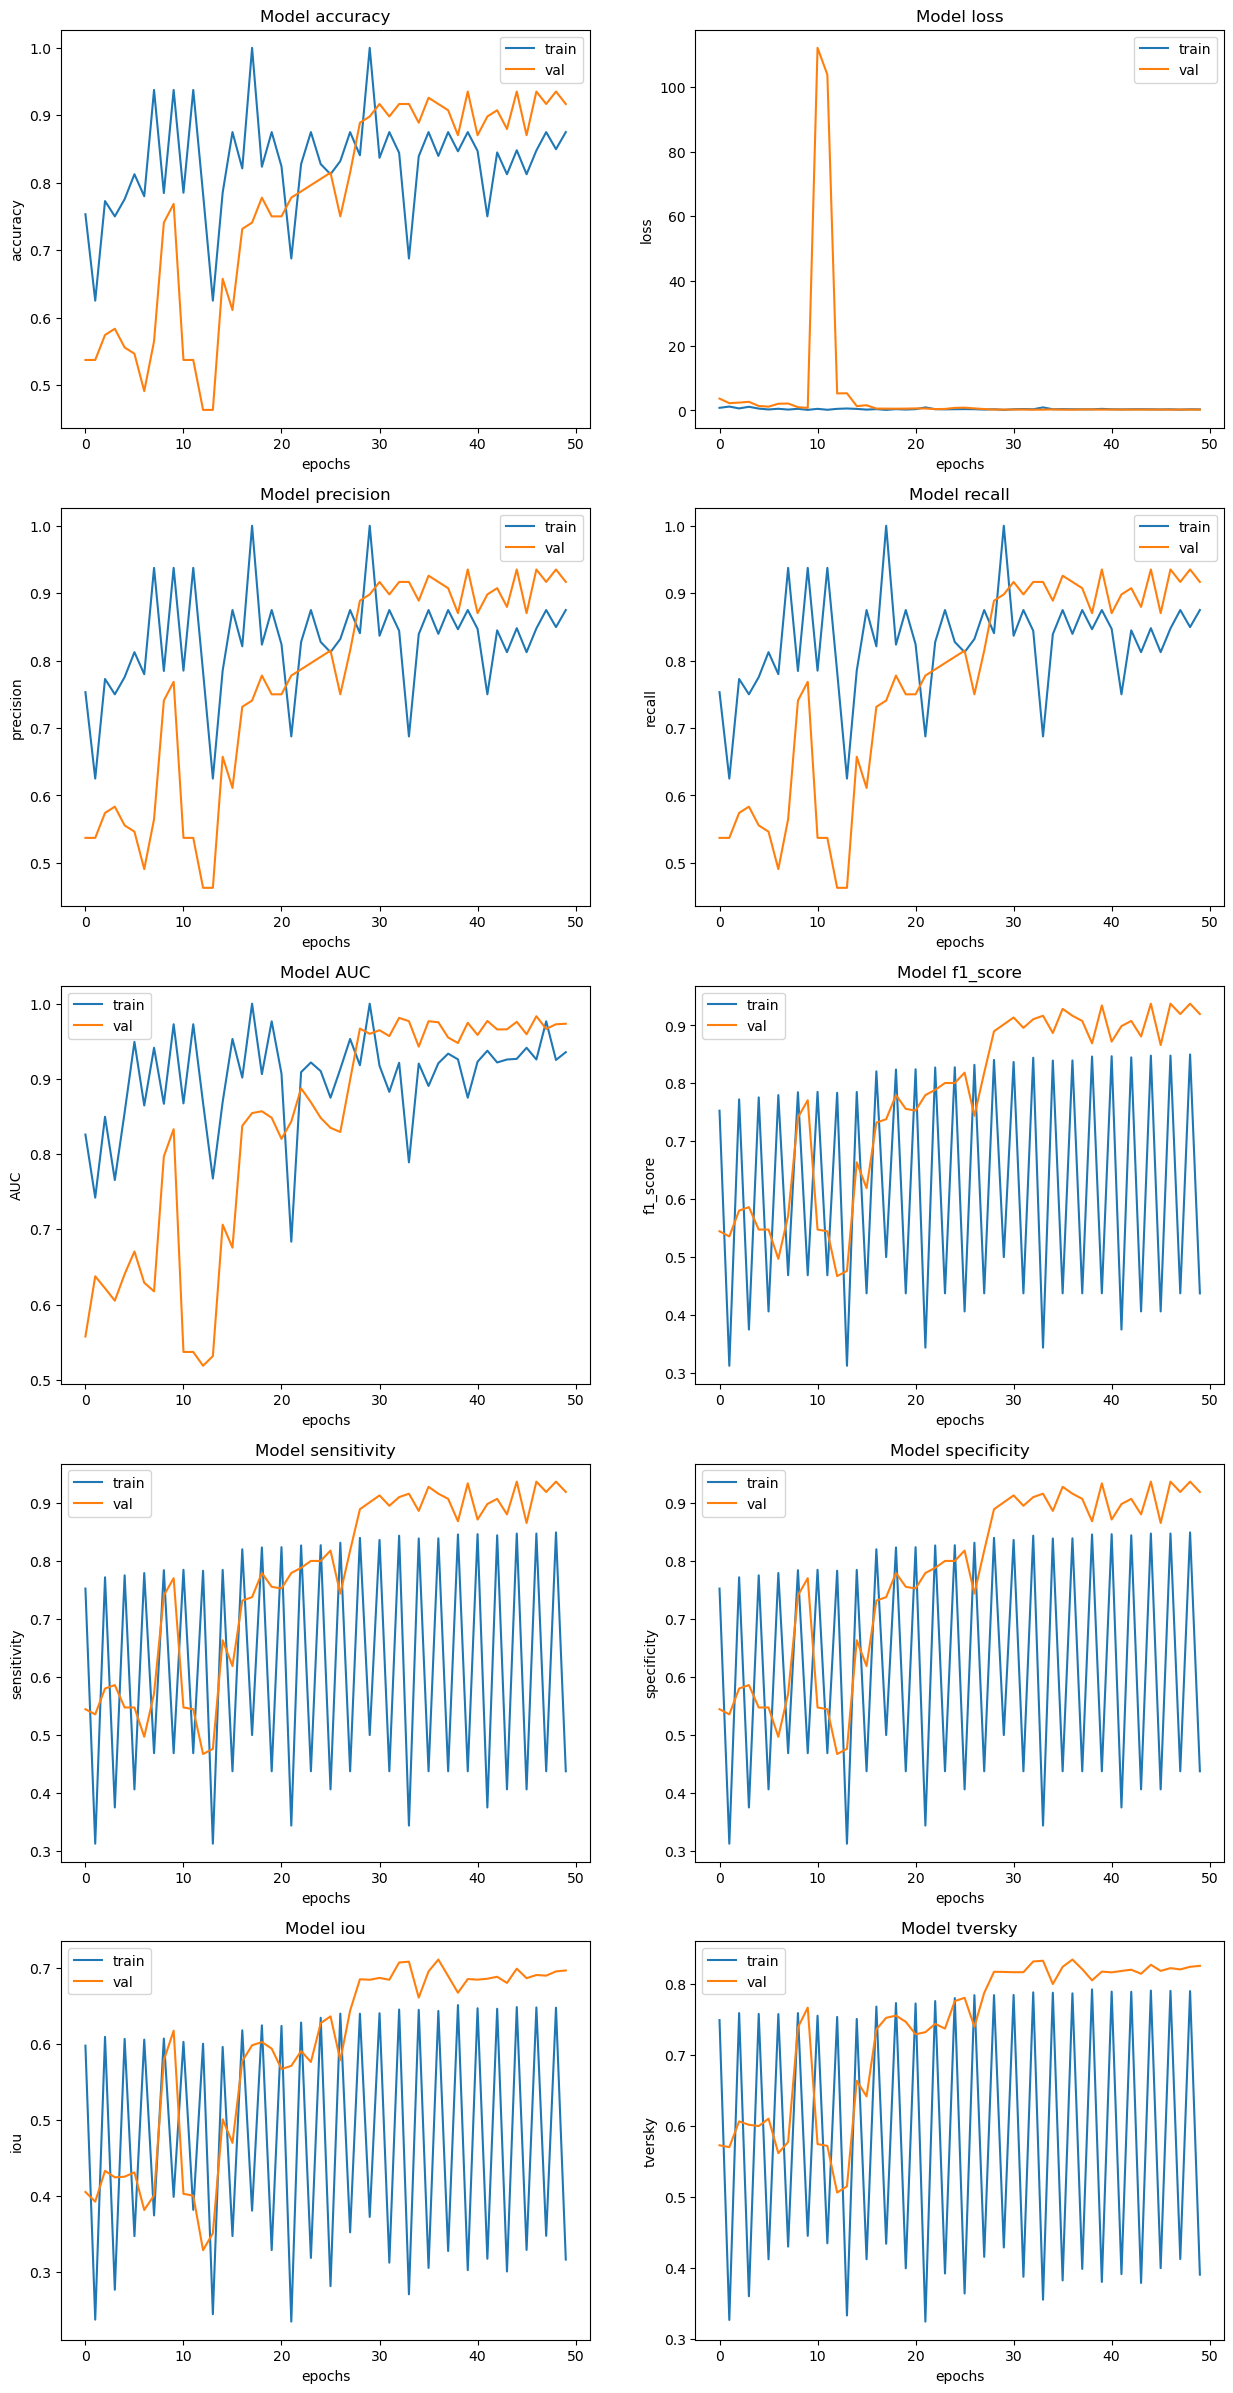

In [249]:
fig, ax = plt.subplots(5, 2, figsize=(15, 30))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss', 'precision', 'recall', 'AUC', 'f1_score', 'sensitivity', 'specificity', 'iou', 'tversky']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model-Results.png")

# Preparing Test Data for Evaluation

In [251]:
Test_data = (data_gen.flow(X2_test, Y_test,
                          batch_size=128, 
                          seed=27,
                          shuffle=True))

# Evaluating the Model on Test Data

In [253]:
print("Evaluate on test data")

Evaluate on test data


In [ ]:
results = model.evaluate(Test_data, batch_size=16, callbacks=callbacks)  # Reduced batch size to 16
print("test loss test acc:", results)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


# Processing Predictions

*Initializing Lists for True and Predicted Labels*

In [ ]:
truey = []
predy = []
x = X2_test
y = Y_test

*Making Predictions*

In [ ]:
yhat = model.predict(x)

*Converting Predictions and True Labels to Lists*

In [ ]:
yh = yhat.tolist()
yt = y.tolist()

# Calculating Accuracy

In [ ]:
count = 0

for i in range(len(y)):
    yy = max(yh[i])
    yyt = max(yt[i])
    predy.append(yh[i].index(yy))
    truey.append(yt[i].index(yyt))
    if(yh[i].index(yy) == yt[i].index(yyt)):
        count += 1

acc = (count / len(y)) * 100

# Saving Results

In [ ]:
np.save('truey', truey)
np.save('predy', predy)
print("The Predicted and True label values are saved")

*Printing Accuracy*

In [ ]:
print("Accuracy on test set :" + str(acc) + "%")

# Plot confusion matrix

In [ ]:
confusion_matrix_img(truey, predy, savename='Confusion Matrix')

# The Percentage of correctly classified images

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
predictions = model.predict(X2_test)
predictions_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(Y_test, axis=1)
conf_mat = confusion_matrix(true_classes, predictions_classes)

def plotScoresHist(conf_mat):
    scores = pd.DataFrame(conf_mat)
    classes = [0, 1]
    p = [scores[i].to_numpy()[i] / scores[i].to_numpy().sum() * 100 for i in classes]
    plt.bar(["Benign", "Malignant"], p, color=['green', 'orange'])
    plt.title("The Percentage of correctly classified images")
    plt.xlabel('Class')
    plt.ylabel('Percentage')
    plt.xticks(["Benign", "Malignant"])
    plt.show()

plotScoresHist(conf_mat)
